In [19]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import networkx as nx
import matplotlib.pyplot as plt
import pickle

In [20]:
data = pd.read_csv('all_courses of Udacity updated.csv')



In [21]:
data.head()

,Title,Type,Description,Level,Duration,Rating,Review Count,Skills Covered,Prerequisites,Affiliates,URL
0,Data Engineering with AWS,nanodegree,"Learn to design data models, build data wareho...",intermediate,4 Months,4.6,1802.0,"AWS Glue, Amazon S3, AWS Data Warehouse, Re...","Intermediate Python, intermediate SQL & comman...",NaN,https://www.udacity.com/course/data-engineer-n...
1,Product Manager,nanodegree,Envision and execute the development of indust...,beginner,4 Months,4.7,864.0,"Product Strategy, Product Design, Product Deve...",No Experience Required,NaN,https://www.udacity.com/course/product-manager...
2,C++,nanodegree,Get hands-on experience building five real-wor...,intermediate,4 Months,4.5,1126.0,"Data Structures & Algorithms, Memory Managemen...",Intermediate Programming,NaN,https://www.udacity.com/course/c-plus-plus-nan...
3,Business Analytics,nanodegree,Gain foundational data skills like analyzing d...,beginner,3 Months,4.8,2649.0,"Excel & Spreadsheets, SQL, Data Visualization,...",None,Mode,https://www.udacity.com/course/business-analyt...
4,Data Scientist,nanodegree,"Build effective machine learning models, run d...",advanced,4 Months,4.7,1212.0,"Machine Learning, Deep Learning, Software Engi...","Python, SQL & Statistics","Bertelsmann, Figure Eight, IBM Watson, Insight...",https://www.udacity.com/course/data-scientist-...


In [22]:
data_cleaned = data.drop_duplicates()

In [23]:
data_cleaned['Description'].fillna('No description available', inplace=True)
data_cleaned['Prerequisites'].fillna('No prerequisites', inplace=True)

In [24]:
string_columns = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[string_columns] = data_cleaned[string_columns].apply(lambda x: x.str.strip())


In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [26]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

In [27]:
print("Generating BERT embeddings. This might take some time...")
data_cleaned['Description_Embedding'] = data_cleaned['Description'].apply(get_bert_embeddings)
data_cleaned['Prerequisites_Embedding'] = data_cleaned['Prerequisites'].apply(get_bert_embeddings)


Generating BERT embeddings. This might take some time...


In [28]:
data_cleaned.to_pickle('processed_data_with_embeddings.pkl')


In [36]:

knowledge_graph = nx.DiGraph()

for _, row in data_cleaned.iterrows():
    course_title = row['Title']
    prerequisites = row['Prerequisites'].split(", ")

    knowledge_graph.add_node(
        course_title,
        type='course', 
        description=row['Description'],
        skills=row['Skills Covered'],
    )

    for prereq in prerequisites:
        if prereq != 'No prerequisites' and prereq.strip():
         
            if not knowledge_graph.has_node(prereq):
                knowledge_graph.add_node(prereq, type='prerequisite')  
            knowledge_graph.add_edge(prereq, course_title, relationship='prerequisite')


In [37]:
with open("knowledge_graph.gpickle", "wb") as f:
    pickle.dump(knowledge_graph, f)

In [38]:
def draw_graph(graph, title="Knowledge Graph", highlight_nodes=None, highlight_edges=None):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42)

    # Node colors
    node_colors = []
    for node in graph.nodes(data=True):
        node_type = node[1].get('type', 'unknown')  
        if highlight_nodes and node[0] in highlight_nodes:
            node_colors.append('lightgreen')
        elif node_type == 'course':
            node_colors.append('skyblue')
        elif node_type == 'prerequisite':
            node_colors.append('lightgrey')
        else:
            node_colors.append('orange') 

    edge_colors = []
    for edge in graph.edges(data=True):
        if highlight_edges and edge in highlight_edges:
            edge_colors.append('red')
        else:
            edge_colors.append('black')

    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=1500,
        font_size=10,
        font_weight='bold',
    )

    edge_labels = nx.get_edge_attributes(graph, 'relationship')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='blue')

    legend_labels = {
        'Course': 'skyblue',
        'Prerequisite': 'lightgrey',
        'Highlighted': 'lightgreen',
        'Unknown': 'orange',
    }
    for label, color in legend_labels.items():
        plt.plot([], [], color=color, marker='o', linestyle='', label=label)
    plt.legend(loc='best')

    plt.title(title)
    plt.show()


In [39]:
def visualize_selected_course(graph, course_title):

    subgraph_nodes = list(graph.predecessors(course_title)) + [course_title]
    subgraph = graph.subgraph(subgraph_nodes)

    highlight_nodes = subgraph_nodes
    highlight_edges = [(prereq, course_title) for prereq in graph.predecessors(course_title)]

    draw_graph(
        subgraph,
        title=f"Knowledge Graph: {course_title} and its Prerequisites",
        highlight_nodes=highlight_nodes,
        highlight_edges=highlight_edges,
    )


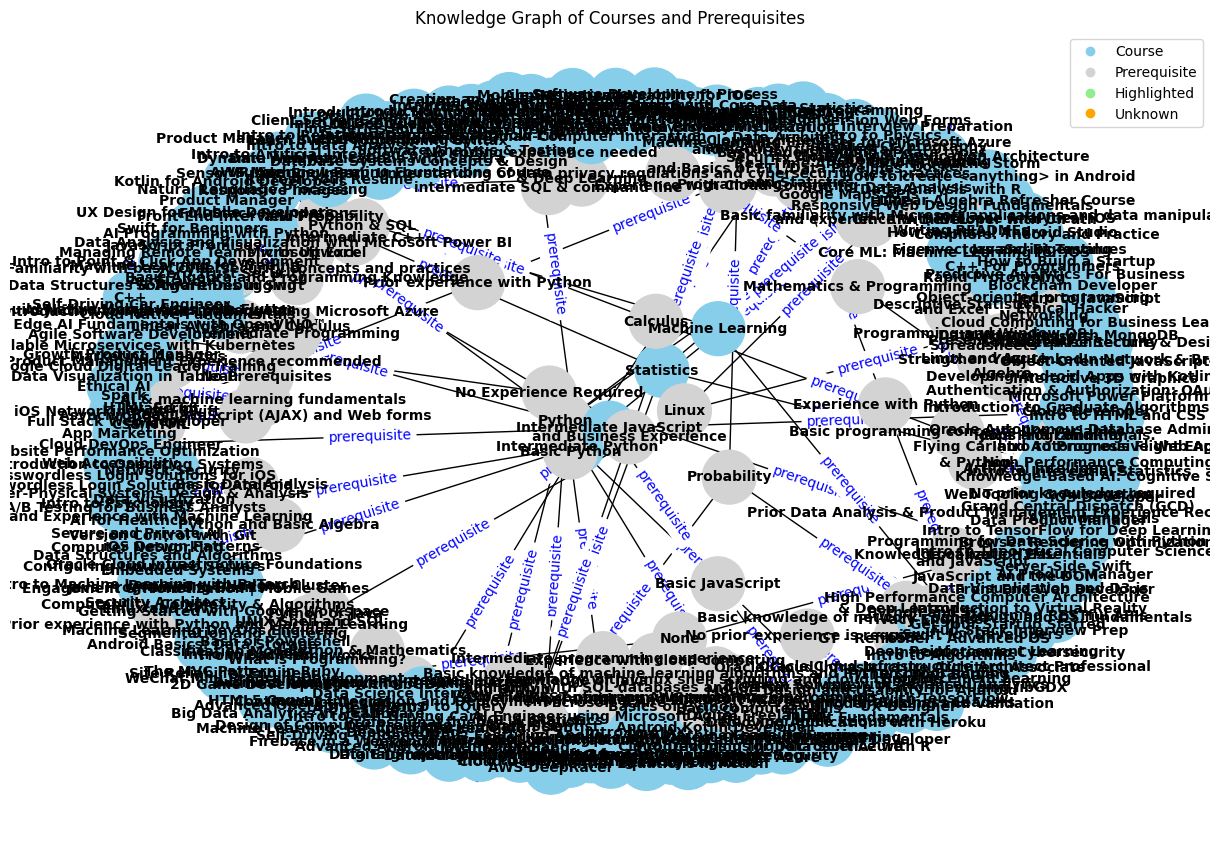

In [40]:
draw_graph(knowledge_graph, title="Knowledge Graph of Courses and Prerequisites")


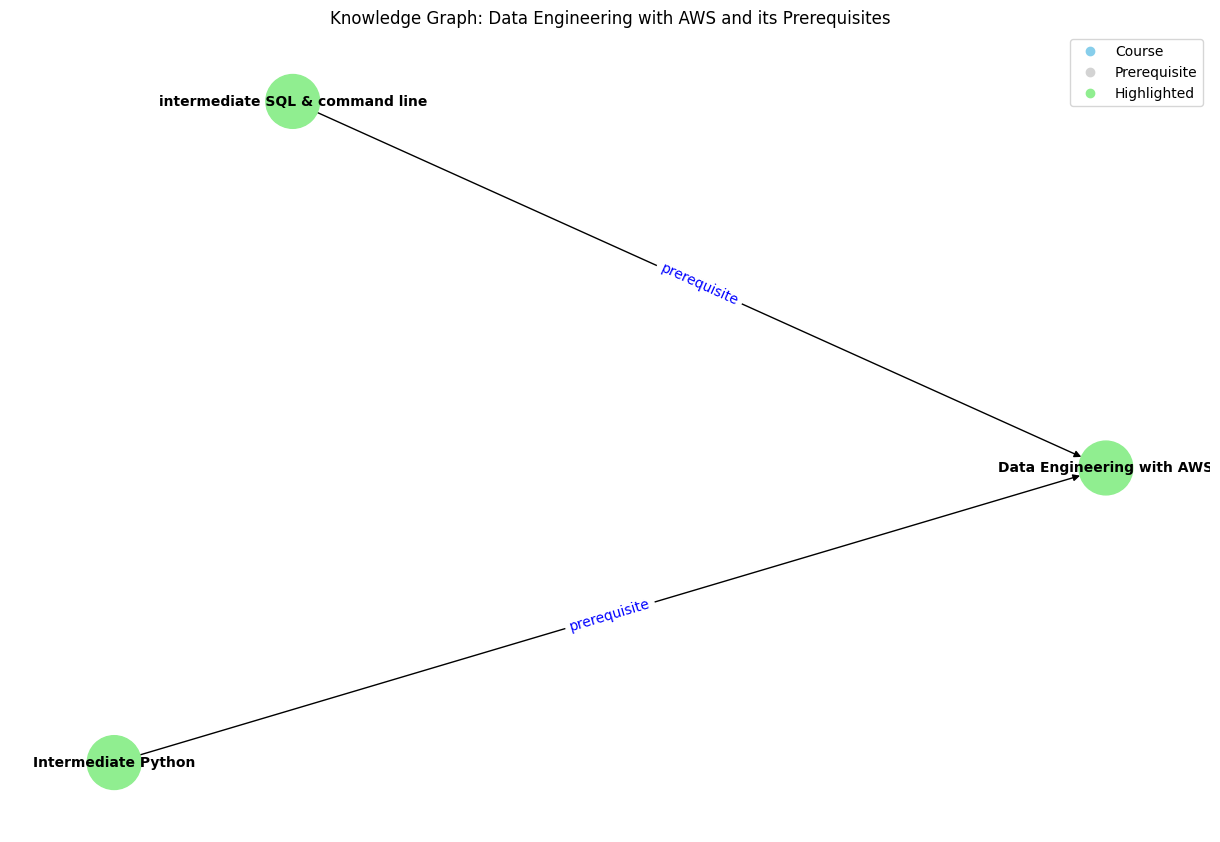

In [34]:
selected_course = 'Data Engineering with AWS'
visualize_selected_course(knowledge_graph, selected_course)